# Homework: Physics-Informed Neural Networks
#### The static, linear Euler-Bernoulli beam

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Content creators: Jasper O. Schommartz

Summer term 2024

---

#### In this notebook, we...

present a PINN impelementation for the linear Euler-Bernoulli beam with pinned support und the left and roller support on the right.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()

## 1. Theory of the geometrically linear Euler-Bernoulli beam

For this task we consider a beam with *pinned* support on the left and *roller* support on the right respectively.

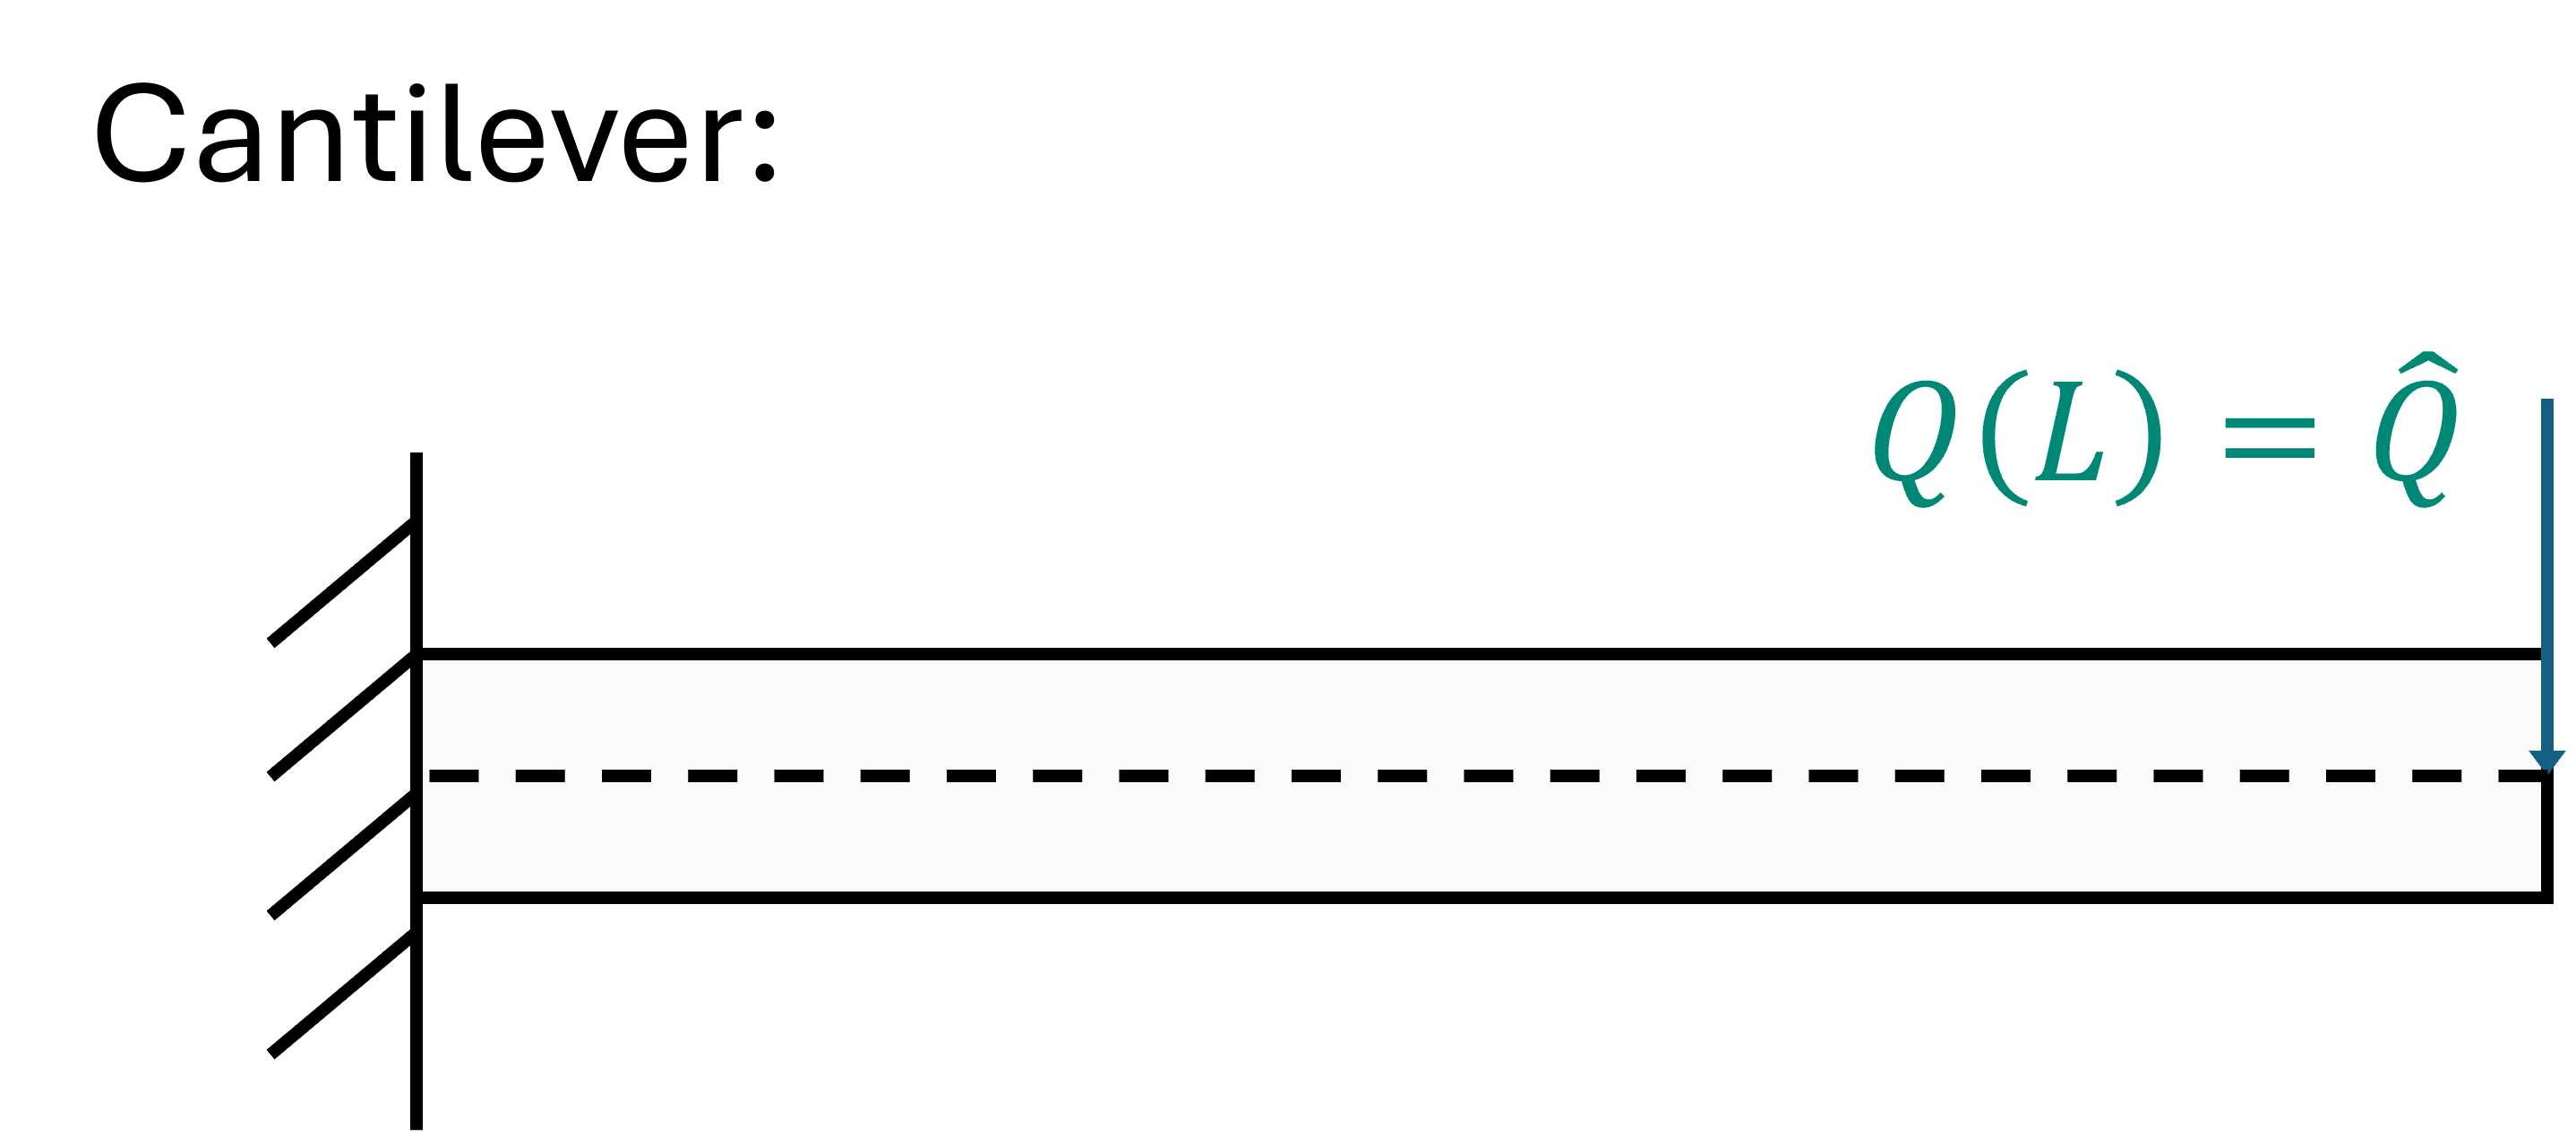

In the nonlinear case, the mechanical behavior of a cantilever beam is described by the coupled partial differential equations (PDEs)

$$
- N' = f(x) \quad\quad\quad\quad\quad (1)
$$
$$
- (Nw')' - M'' = q(x) \quad\quad(2),
$$

where $N = EA (u' + 0.5 (w')^2)$ and $M = - EI w ''$. The PDEs describe the balance of momentum in horizontal and vertical direction, respectively. If we assume the vertical displacements $w$ to be small, the PDEs can be decoupled, enabling separate computation of $u$ and $w$. In this task we are going to consider the vertical component of the decoupled system, which we refer to as the *linear Euler-Bernoulli beam*.

**Linear Euler-Bernoulli beam**

The mechanical behavior of the beam is decribed by a fourth order differential equation, which reads

$$
EI w^{(4)} = q(x).
$$

Here, $w$ is the vertical displacement and $q(x)$ denotes a transversal line load depending on the horizontal location $x$. The Young's modulus and the moment of inertia are denoted by $E$ and $I$, respectively. The Dirichlet boundary conditions of the cantilever beam are given by

$$
w(0) = w(L) = 0
$$

and the Neumann boundary conditions read

$$
M(0) = M(L) = 0.
$$

### Non-dimensionalization:

As the Young's modulus $E$ and the moment of intertia $I$ can take large/small values in practice, it can be benefitial to non-dimensionalize the equations before training a physics-informed neural network (PINN). Therefore, we introduce the non-dimensional variables $\hat{x}$ and $\hat{w}$ as

$$ x = x_c \cdot \hat{x}\quad\text{and}\quad w = w_c \cdot \hat{w}, $$

and the non-dimensional derivatives $\hat{w}'$, $\hat{w}''$, $\hat{w}'''$, $\hat{w}^{(4)}$ as

$$ w' = \frac{w_c}{x_c} \hat{w}',\quad w'' = \frac{w_c}{x_c^2} \hat{w}'',\quad w''' = \frac{w_c}{x_c^3} \hat{w}''',\quad w^{(4)} = \frac{w_c}{x_c^4} \hat{w}^{(4)},$$

We choose $x_c = L$, which after insertion into the differential equation yields

$$
w_c = \frac{L^4}{E I}
$$

The *non-dimensional boundary value problem* (BVP) ultimatly reads

$$
\hat{w}^{(4)} = \frac{x_c^4}{EI w_c} q(x_c \cdot \hat{x})
$$

with 

$$
\hat{w}(0) = \hat{w}(1) = 0
$$

and

$$
\hat{w}''(0) = \hat{w}''(1) = 0
$$


## 2. PINN model

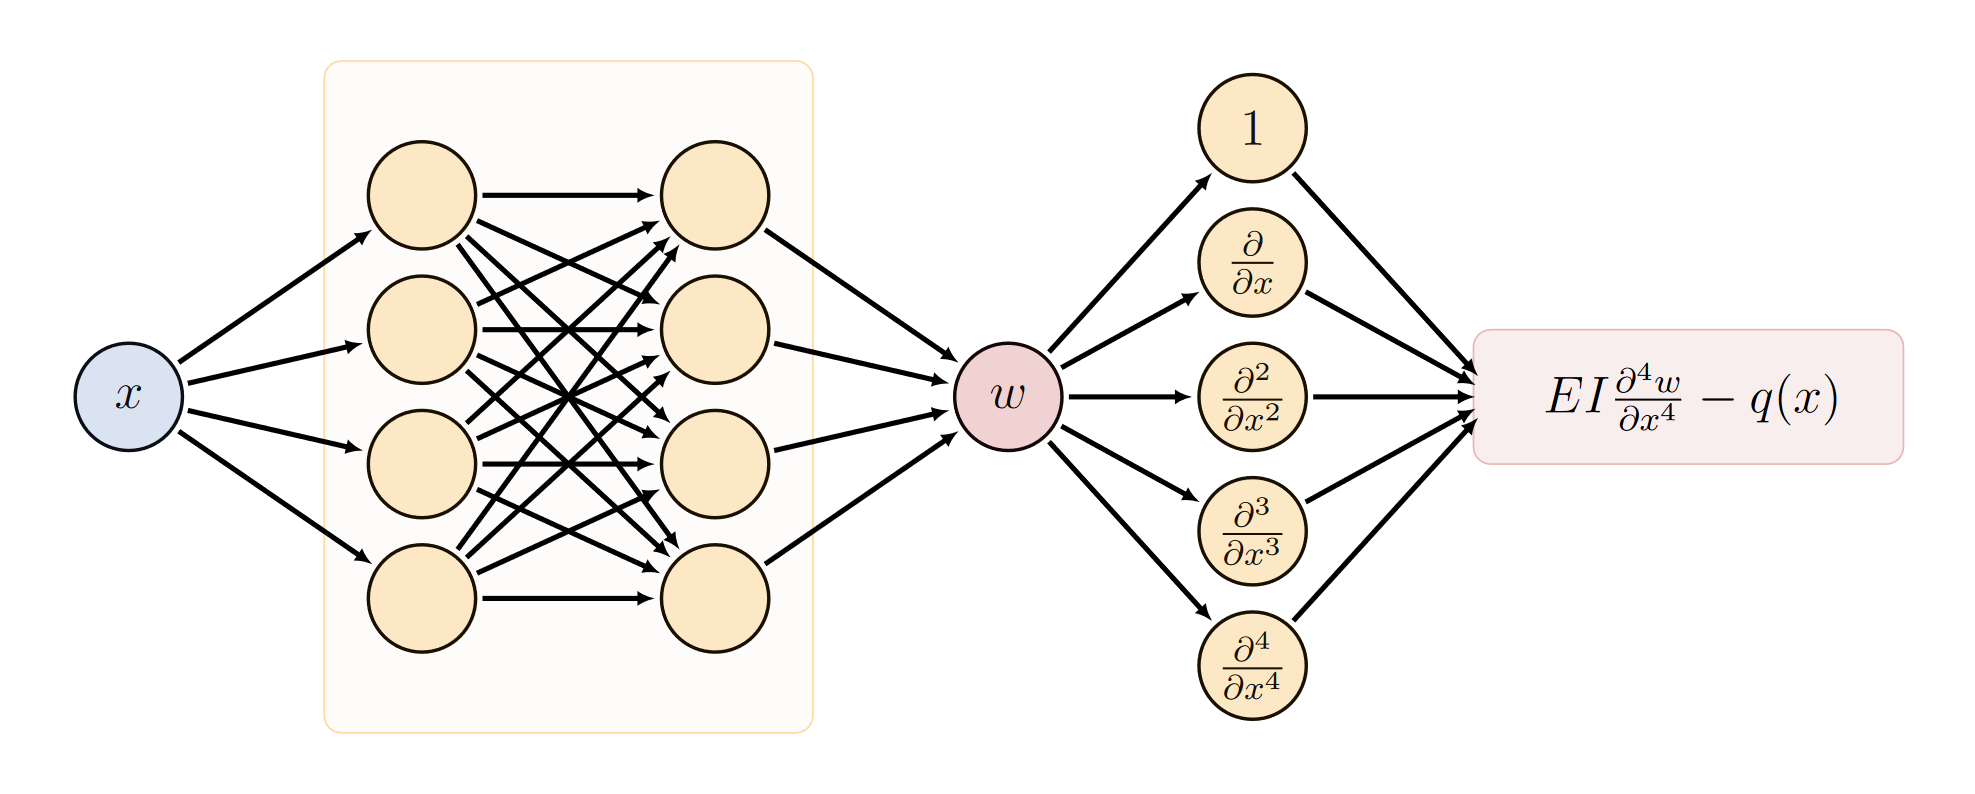

PINNs enforce the physicality of the solution in a weak manner via the loss $\mathcal{L}$. In its simplest form the loss consits of three parts and reads

$$
\mathcal{L} = \mathcal{L}_{data} + \mathcal{L}_{PDE} + \mathcal{L}_{BC}.
$$

Here, $\mathcal{L}_{data}$, denotes the error on a set of labeled data, $\mathcal{L}_{PDE}$ denotes the error of the underlying partial differential equations, and $\mathcal{L}_{BC}$ is the error of the boundary conditions. For this task we define the losses in terms of the non-dimensional variables $\hat{x}$ and $\hat{w}$ as

$$
\mathcal{L}_{DATA} = w_{DATA} \frac{1}{N_{DATA}} \sum_{i=1}^{N_{DATA}} \lvert\lvert \text{NN}(\hat{x}_i) - \hat{w}_i \rvert\rvert_{2}^2
$$
$$
\mathcal{L}_{PDE} = w_{PDE} \frac{1}{N_{PDE}} \sum_{i=1}^{N_{PDE}} \Big\lvert\Big\lvert \frac{\partial^4 \text{NN}(\hat{x}_i)}{\partial \hat{x}^4} - \frac{x_c^4}{EI w_c} q(x_c \cdot \hat{x}) \Big\rvert\Big\rvert_{2}^2
$$
$$
\begin{split}
\mathcal{L}_{BC} = \frac{1}{2} &w_{DIR} \frac{1}{2} \left[ \lvert\lvert \text{NN}(0) \rvert\rvert_{2}^2  + \lvert\lvert \text{NN}(1) \rvert\rvert_{2}^2 \right] + \\ 
\frac{1}{2} &w_{NEU} \frac{1}{2} \left[ \Big\lvert\Big\lvert \frac{\partial^2 \text{NN}(\hat{x}_i)}{\partial \hat{x}^2}\Big\rvert_{\hat{x}_i=0} \Big\rvert\Big\rvert_{2}^2  + \Big\lvert\Big\lvert \frac{\partial^2 \text{NN}(\hat{x}_i)}{\partial \hat{x}^2}\Big\rvert_{\hat{x}_i=1} \Big\rvert\Big\rvert_{2}^2 \right].
\end{split}
$$

Each of the loss terms correspond to a weighted *mean squared error* with $w_{DATA}$, $w_{PDE}$, $w_{DIR}$ and $w_{NEU}$ denoting the weights of labeled data, the partial differential euqation, the Dirichlet boundary conditions and the Neumann boundary conditions, respectively.

**Implementaion**

The architecture and loss function presented above can be implemented as follows: First, we create a Tensorflow layer for the FFNN, i.e., `MLP`, and functions for the first to fourth derivatives with respect to $x$, i.e., `gradient()`, `second_gradient()`, `third_gradient()` and `fourth_gradient()`.

In [2]:
class MLP(layers.Layer):
    ''' A feed-forward neural network '''
    def __init__(self, units, activation):
        super().__init__()
        self.ls = []
        for (u, a) in zip(units, activation):
            self.ls += [layers.Dense(u, a)]

    def call(self, x):    
        for l in self.ls:
            x = l(x)
        return x

def gradient(f, x):
    ''' Computes the first derivative of a function f '''
    with tf.GradientTape() as g:
        g.watch(x)
        u = f(x)
    du = tf.squeeze(g.batch_jacobian(u, x), 2)
    return u, du

def second_gradient(f, x):
    ''' Computes the second derivative of a function f '''
    with tf.GradientTape() as g:
        g.watch(x)
        u, du = gradient(f, x)
    ddu = tf.squeeze(g.batch_jacobian(du, x), 2)
    return u, du, ddu

def third_gradient(f, x):
    ''' Computes the third derivative of a function f '''
    with tf.GradientTape() as g:
        g.watch(x)
        u, du, ddu = second_gradient(f, x)
    dddu = tf.squeeze(g.batch_jacobian(ddu, x), 2)
    return u, du, ddu, dddu

def fourth_gradient(f, x):
    ''' Computes the fourth derivative of a function f '''
    with tf.GradientTape() as g:
        g.watch(x)
        u, du, ddu, dddu = third_gradient(f, x)
    ddddu = tf.squeeze(g.batch_jacobian(dddu, x), 2)
    return u, du, ddu, dddu, ddddu

Next, the `PINN` is implemented based on the nondimenional BVP for the linear Euler-Bernoulli cantilever beam. The `PINN` layer computes the four constituents of the loss function. That is, the residual of the differential equation, `res_pde`, the resuiduals of the Dirichlet and Neumann boundary conditions, `res_dir_bc` and `res_neu_bc`, and the residual of the labeled data `res_data`.

The properties `self.w_pde`, `self.w_dir`, `self.w_neu`, `self.w_data` are scaling factors that define the weighting of every term in the loss function. 

**Note** that the PINN receives dimensional data as inputs for `labeled_data` and `x`, which is nondimensionalized within the PINN layer before passing it to the FFNN and the loss terms.

In [3]:
class PINN(layers.Layer):
    ''' Physics-informed neural network for the non-dimensional, linear Euler-Bernoulli beam '''
    def __init__(self, w_pde, w_dir, w_neu, w_data, param, labeled_data=None, **kwargs):
        super().__init__()
        # Create a FFNN
        self.mlp = MLP(**kwargs)

        # Weights
        self.w_pde = tf.constant(w_pde, dtype=tf.float32)
        self.w_dir = tf.constant(w_dir, dtype=tf.float32)
        self.w_neu = tf.constant(w_neu, dtype=tf.float32)
        self.w_data = tf.constant(w_data, dtype=tf.float32)

        # Beam parameters
        self.EA = tf.constant(param[0] * param[1], dtype=tf.float32)
        self.EI = tf.constant(param[0] * param[2], dtype=tf.float32)

        # Nondimensional parameters
        self.x_c = tf.constant(param[3], dtype=tf.float32)
        self.w_c = self.x_c / self.EI

        # x-values of the Dirichlet BCs
        self.zero = tf.zeros([1,1])
        self.L = tf.ones([1,1]) * param[3]

        # Constant line load
        self.q = tf.constant(50., dtype=tf.float32)

        # Labeled data of the form [x, w]
        self.labeled_data_x = tf.constant(labeled_data[0], dtype=tf.float32) / self.x_c
        self.labeled_data_w = tf.constant(labeled_data[1], dtype=tf.float32) * self.w_c ** (-1)

    def call(self, x):
        ''' Main PINN function '''
        # nondimensionalize input
        x = x / self.x_c

        # evaluate MLP and outputs
        w, dw, ddw, dddw, ddddw = fourth_gradient(self.mlp, x)
        M = self._moment(ddw)
        Q = self._transversal_force(dddw)

        w0, _, ddw0 = second_gradient(self.mlp, self.zero)
        wL, _, ddwL = second_gradient(self.mlp, self.L / self.x_c)

        # pde residual
        res_pde = tf.reduce_mean(
            tf.square(self._pde_residual(ddddw))
        )

        # Dirichlet boundary condition residuals
        res_dir_bc = (
            tf.square(w0)
            + tf.square(wL)
        ) / 2

        # Neumann boundary condition residuals
        res_neu_bc = (
            tf.square(ddw0)
            + tf.square(ddwL)
        ) / 2

        # labeled data residual
        res_data = self._labeled_data_residual()

        # assemble and add loss term
        total_loss = self.w_pde * res_pde + (self.w_dir * res_dir_bc + self.w_neu * res_neu_bc) / 2 + self.w_data * res_data
        self.add_loss(total_loss)

        return (
            w * self.w_c,
            dw * self.w_c / self.x_c,
            M, 
            Q,
            ddddw * self.w_c / tf.math.pow(self.x_c, 4)
        )
    
    def _pde_residual(self, ddddw):
        ''' Computes the residual of the differential equation'''
        return self.q / self.EI / self.w_c * tf.math.pow(self.x_c, 4) - ddddw

    def _labeled_data_residual(self):
        ''' Computes the data loss using the mean squared error '''
        w = self.mlp(self.labeled_data_x)
        return tf.reduce_mean(tf.square(w - self.labeled_data_w))

    def _transversal_force(self, dddw):
        ''' Computes the transversal force '''
        return - self.EI * self.w_c / tf.math.pow(self.x_c, 3) * dddw
    
    def _moment(self, ddw):
        ''' Computes the bending moment '''
        return - self.EI * self.w_c / tf.square(self.x_c) * ddw

The PINN model can be generated by calling the `build()` function.

In [4]:
def build(*args, **kwargs):
    ''' Builds an evaluation model that returns the nodal displacements '''
    # define input shape
    x = tf.keras.Input(shape=(1,))
    # define which (custom) layers the model uses
    pinn = PINN(*args, **kwargs)
    w, dw, M, Q, ddddw = pinn(x)
    # connect input and output
    model = tf.keras.Model(inputs = [x], outputs = [w, dw, M, Q, ddddw])
    # define optimizer
    model.compile('adam')
    return model

## 3. Analytical data generation

The differential equation of the linear elastic Euler-Bernoulli beam can be solved analytically. The solution reads

$$
EI w(x) = (x^4 - 2 L x^3 + L^3 x) \frac{q}{24}
$$

In [5]:
convert = lambda x: tf.expand_dims(tf.constant(x, dtype='float32'), axis=1)

def analytical_ebb(EI, q, L, x):
    ''' Data genereation with the analytical solution of 
     the linear Euler-Bernoulli beam '''
    # compute analytical solution
    w = (x ** 4 - 2 * L * x ** 3 + L ** 3 * x) * q / 24 / EI
    dw = (4 * x ** 3 - 6 * L * x ** 2 + L ** 3) * q / 24 / EI
    M = - (x ** 2 - L * x) * q / 2
    Q = - (2 * x - L) * q / 2
    ddddw = q * np.ones(x.shape) / EI

    # convert to tensors
    x = convert(x)
    w = convert(w)
    dw = convert(dw)
    M = convert(M)
    Q = convert(Q)
    ddddw = convert(ddddw)

    return x, w, dw, M, Q, ddddw

After choosing a number of collocation points `n` and setting a value for the line load `q`, the data is generated using the the analytical model.

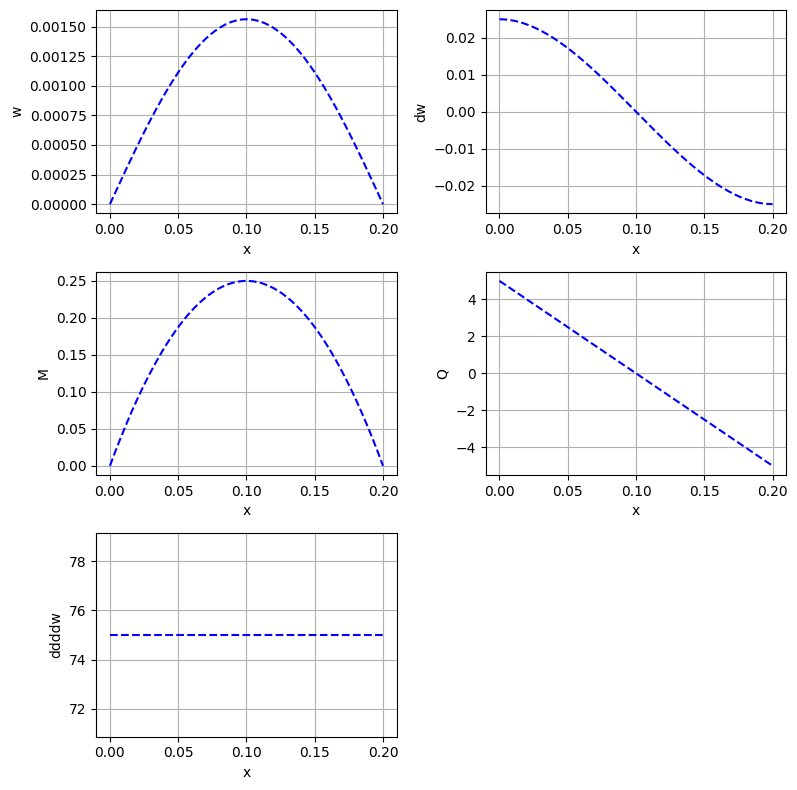

In [6]:
# Beam properties
L = 0.2            # Length [m]
W = 0.02           # Width [m]
H = 0.02           # Height [m]
E = 50e6           # Young's modulus [Pa]

# Cross-section parameters (assuming rectangular cross-section)
A = W * H
I = H ** 3 * W / 12
param = [E, A, I, L]

# Compute the analytical solution
n = 201 # number of collocation points
q = 50. # Transversal line load
x = np.linspace(0, L, n)

x, w, dw, M, Q, ddddw = analytical_ebb(E * I, q, L, x)

# Plot data
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
axs[0, 0].plot(x, w, 'b', linestyle='--')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('w')
axs[0, 0].grid()

axs[0, 1].plot(x, dw, 'b', linestyle='--')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('dw')
axs[0, 1].grid()

axs[1, 0].plot(x, M, 'b', linestyle='--')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('M')
axs[1, 0].grid()

axs[1, 1].plot(x, Q, 'b', linestyle='--')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('Q')
axs[1, 1].grid()

axs[2, 0].plot(x, ddddw, 'b', linestyle='--')
axs[2, 0].set_xlabel('x')
axs[2, 0].set_ylabel('ddddw')
axs[2, 0].grid()

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()

## 4. Build and calibrate PINN model

The `build()` function is called with the desired `units`, i.e., node number, and `activation` functions. Futhermore, the weights for PDE, Dirichlet, Neumann, and data losses can be set by adjusting the values of `WPDE`, `WDIR`, `WNEU`, and `WDATA`, respectively.

Note, that we can pass `labeled_data` to the model. In practice this can be useful if measured data shall be included in the training process.

In [7]:
# Loss weights
WPDE = 1.
WDIR = 100.
WNEU = 1.
WDATA = 0.

# Load model
model = build(WPDE, WDIR, WNEU, WDATA, param,
    labeled_data=[x, w],
    units=[8, 1],
    activation=['softplus', 'linear']
)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 pinn (PINN)                 ((None, 1),               25        
                              (None, 1),                         
                              (None, 1),                         
                              (None, 1),                         
                              (None, 1))                         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Next, the model is fitted to the training data after defining the number of training epochs, i.e, `NEPOCHS`, and the learning rate for the ADAM optimizer. As opposed to the previous tasks, PINNs can perform **unsupervised** learining, meaning that no labeled output data has to be provided for training. Since Tensorflow still requires the definition of output values in the `fit()` function, we pass the dummy outputs `[x, x, x, x, x]`.

Epoch 1/10000
32/32 - 2s - loss: 9.0851 - 2s/epoch - 70ms/step
Epoch 2/10000
32/32 - 0s - loss: 4.5643 - 24ms/epoch - 754us/step
Epoch 3/10000
32/32 - 0s - loss: 2.9969 - 24ms/epoch - 739us/step
Epoch 4/10000
32/32 - 0s - loss: 2.1158 - 18ms/epoch - 558us/step
Epoch 5/10000
32/32 - 0s - loss: 1.5129 - 29ms/epoch - 896us/step
Epoch 6/10000
32/32 - 0s - loss: 1.0867 - 13ms/epoch - 406us/step
Epoch 7/10000
32/32 - 0s - loss: 0.7852 - 34ms/epoch - 1ms/step
Epoch 8/10000
32/32 - 0s - loss: 0.5745 - 16ms/epoch - 491us/step
Epoch 9/10000
32/32 - 0s - loss: 0.4300 - 33ms/epoch - 1ms/step
Epoch 10/10000
32/32 - 0s - loss: 0.3332 - 18ms/epoch - 551us/step
Epoch 11/10000
32/32 - 0s - loss: 0.2700 - 28ms/epoch - 870us/step
Epoch 12/10000
32/32 - 0s - loss: 0.2299 - 16ms/epoch - 494us/step
Epoch 13/10000
32/32 - 0s - loss: 0.2052 - 32ms/epoch - 1ms/step
Epoch 14/10000
32/32 - 0s - loss: 0.1905 - 30ms/epoch - 927us/step
Epoch 15/10000
32/32 - 0s - loss: 0.1819 - 16ms/epoch - 488us/step
Epoch 16/1000

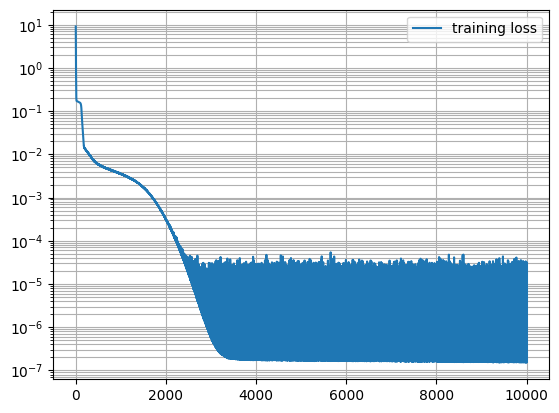

In [8]:
# Create collocation points
NCAL = 1000 # number of collocation points
x_cal = tf.expand_dims(tf.convert_to_tensor(np.linspace(0, L, NCAL), dtype=tf.float32), 1)

# Calibrate model
NEPOCHS = 10000
model.optimizer.learning_rate.assign(0.001)
h = model.fit([x_cal], [x_cal, x_cal, x_cal, x_cal, x_cal],
              epochs=NEPOCHS,
              verbose=2,
              batch_size=32)

plt.semilogy(np.linspace(1, NEPOCHS, NEPOCHS), h.history['loss'], label='training loss')
plt.grid(which='both')
plt.legend()
plt.show()

In [9]:
# Save weights
model.save_weights('weights_lebb_02.h5')

In [10]:
# Load weights to skip the training
model.load_weights('weights_lebb_02.h5')

## 5. Evaluation

To evaluate the performance of the PINN we compare its predictions to the analytical solution.

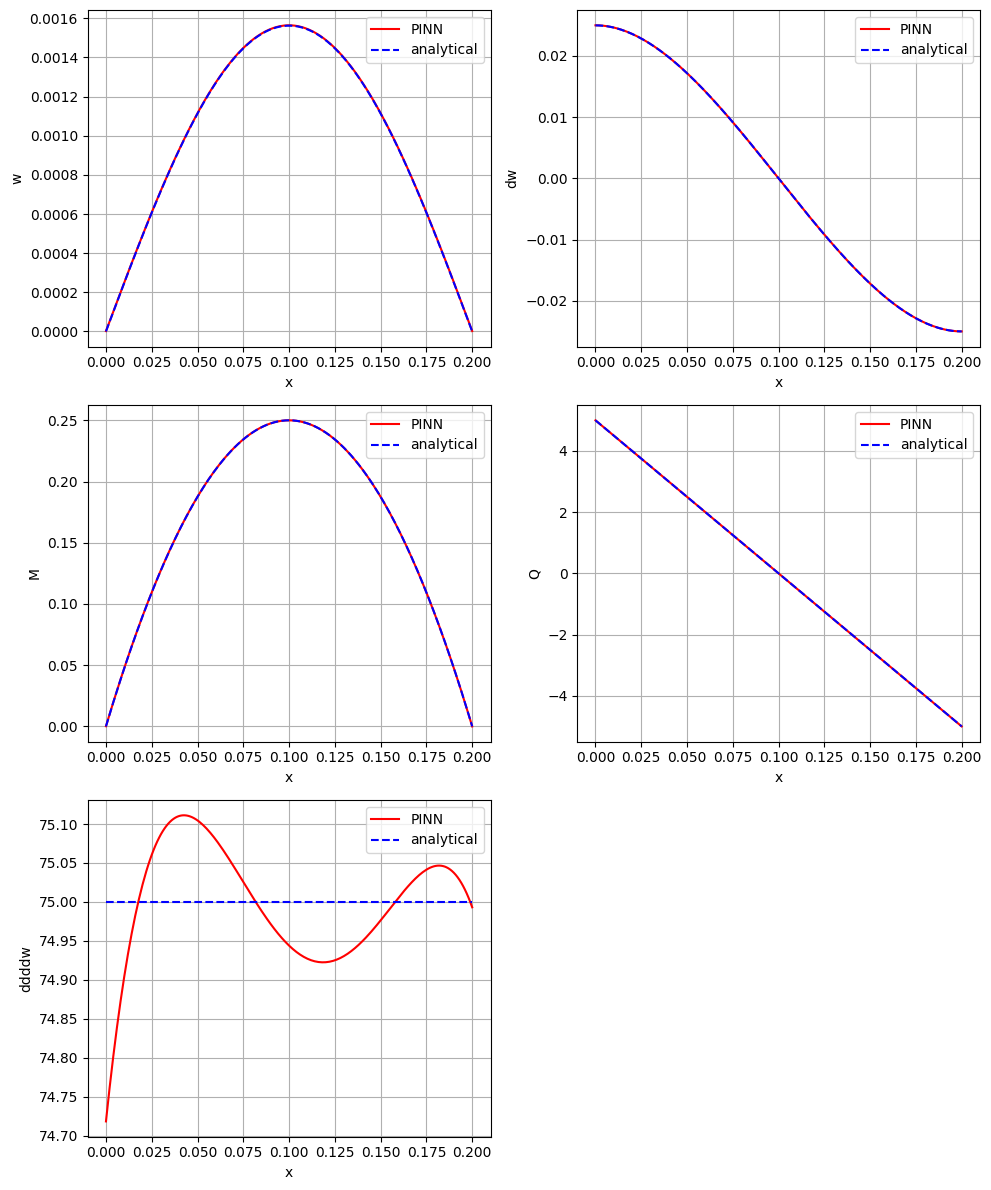

In [11]:
# Get model predictions
w_pinn, dw_pinn, M_pinn, Q_pinn, ddddw_pinn = model(x)

# Plot data and prediction
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
axs[0, 0].plot(x, w_pinn, 'r', label='PINN')
axs[0, 0].plot(x, w, 'b', linestyle='--', label='analytical')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('w')
axs[0, 0].grid()
axs[0, 0].legend()

axs[0, 1].plot(x, dw_pinn, 'r', label='PINN')
axs[0, 1].plot(x, dw, 'b', linestyle='--', label='analytical')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('dw')
axs[0, 1].grid()
axs[0, 1].legend()

axs[1, 0].plot(x, M_pinn, 'r', label='PINN')
axs[1, 0].plot(x, M, 'b', linestyle='--', label='analytical')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('M')
axs[1, 0].grid()
axs[1, 0].legend()

axs[1, 1].plot(x, Q_pinn, 'r', label='PINN')
axs[1, 1].plot(x, Q, 'b', linestyle='--', label='analytical')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('Q')
axs[1, 1].grid()
axs[1, 1].legend()

axs[2, 0].plot(x, ddddw_pinn, 'r', label='PINN')
axs[2, 0].plot(x, ddddw, 'b', linestyle='--', label='analytical')
axs[2, 0].set_xlabel('x')
axs[2, 0].set_ylabel('ddddw')
axs[2, 0].grid()
axs[2, 0].legend()

axs[2, 1].axis("off")

plt.tight_layout()
plt.show()